In [567]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import scipy.stats as stats
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif


# Load the datasets
demographic = pd.read_csv('Dataset/demographic.csv')
examination = pd.read_csv('Dataset/examination.csv')
labs = pd.read_csv('Dataset/labs.csv')
questionnaire = pd.read_csv('Dataset/questionnaire.csv')

# Select relevant features from each dataset
# Demographic features
demo_features = demographic[['SEQN', 'RIAGENDR', 'RIDAGEYR']]
# Rename demographic columns
demo_features.columns = ['ID', 'Gender', 'Age']

# Examination features
exam_features = examination[['SEQN', 'BMXBMI', 'BPXDI1']]
# Rename examination columns
exam_features.columns = ['ID', 'BMI', 'BloodPressure'] # Diastolic = 張開 ; Systolic_BP = 收縮 ; Diastolic_BP = BloodPressure In Pima

# Lab features
lab_features = labs[['SEQN', 'LBXGLT', 'LBXIN']]  # LBXIN = Insulin (uU/mL) (no specify 2Hour)
# Rename lab columns
lab_features.columns = ['ID', 'Glucose', 'Insulin']

# Questionnaire features
quest_features = questionnaire[['SEQN', 'DIQ010']]
quest_features.columns = ['ID', 'Outcome']

# Merge all datasets
merged_data = demo_features.merge(exam_features, on='ID', how='left')\
    .merge(lab_features, on='ID', how='left')\
    .merge(quest_features, on='ID', how='left')

# Create category mappings
gender_map = {1: 'Male', 2: 'Female'}


# Apply mappings
merged_data['Gender'] = merged_data['Gender'].map(gender_map)


# Convert categorical variables to dummy variables
merged_data = pd.get_dummies(merged_data, columns=['Gender'])

In [568]:
demographic

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,3.0,4.0,NaN,13281.237386,13481.042095,1,112,4.0,4.0,0.84
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,4.0,1.0,3.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,3.0,1.0,4.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,5.0,1.0,5.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,3.0,NaN,NaN,27141.631824,28115.568221,1,104,77.0,77.0,NaN
10171,83728,8,2,2,2,24.0,1,1,2.0,24.0,...,3.0,1.0,3.0,15274.475360,16512.138781,1,107,8.0,8.0,1.95
10172,83729,8,2,2,42,NaN,4,4,2.0,NaN,...,5.0,3.0,NaN,24122.248900,26902.344381,1,104,7.0,7.0,3.66
10173,83730,8,2,1,7,NaN,2,2,1.0,84.0,...,4.0,1.0,3.0,25521.878546,26686.025573,2,109,6.0,6.0,1.05


# Load merged dataset information

In [570]:
# Load merged dataset information
merged_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome,Gender_Female,Gender_Male
0,73557,69,26.7,72.0,NaN,NaN,1.0,False,True
1,73558,54,28.6,62.0,NaN,NaN,1.0,False,True
2,73559,72,28.9,90.0,NaN,5.83,1.0,False,True
3,73560,9,17.1,38.0,NaN,NaN,2.0,False,True
4,73561,73,19.7,86.0,NaN,6.12,2.0,True,False
...,...,...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.0,108.0,3.76,2.0,False,True
10171,83728,2,15.9,NaN,NaN,NaN,2.0,True,False
10172,83729,42,34.0,82.0,NaN,NaN,2.0,True,False
10173,83730,7,16.1,NaN,NaN,NaN,2.0,False,True


# Data type & Null count

In [572]:
# Data type & Null count
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175 entries, 0 to 10174
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10175 non-null  int64  
 1   Age            10175 non-null  int64  
 2   BMI            9055 non-null   float64
 3   BloodPressure  7172 non-null   float64
 4   Glucose        2345 non-null   float64
 5   Insulin        3093 non-null   float64
 6   Outcome        9769 non-null   float64
 7   Gender_Female  10175 non-null  bool   
 8   Gender_Male    10175 non-null  bool   
dtypes: bool(2), float64(5), int64(2)
memory usage: 576.4 KB


# Check for null values in the entire dataset

In [574]:
# Check for null values in the entire dataset
print("Null values in each column:")
print(merged_data.isnull().sum())

# Check for null values in specific columns
print("Null values in Age column: {0}".format(merged_data['Age'].isnull().sum()))
print("Null values in BMI column: {0}".format(merged_data['BMI'].isnull().sum()))
print("Null values in BloodPressure column: {0}".format(merged_data['BloodPressure'].isnull().sum()))
print("Null values in Glucose column: {0}".format(merged_data['Glucose'].isnull().sum()))
print("Null values in Insulin column: {0}".format(merged_data['Insulin'].isnull().sum()))


Null values in each column:
ID                  0
Age                 0
BMI              1120
BloodPressure    3003
Glucose          7830
Insulin          7082
Outcome           406
Gender_Female       0
Gender_Male         0
dtype: int64
Null values in Age column: 0
Null values in BMI column: 1120
Null values in BloodPressure column: 3003
Null values in Glucose column: 7830
Null values in Insulin column: 7082


# Fill null values with 0 in the entire dataset

In [576]:
# Fill null values with 0 in the entire dataset
merged_data = merged_data.fillna(0)

# Alternatively, fill null values with 0 in specific columns
merged_data['Age'] = merged_data['Age'].fillna(0)
merged_data['BMI'] = merged_data['BMI'].fillna(0)
merged_data['BloodPressure'] = merged_data['BloodPressure'].fillna(0)
merged_data['Glucose'] = merged_data['Glucose'].fillna(0)
merged_data['Insulin'] = merged_data['Insulin'].fillna(0)

# Check the dataset to ensure null values are replaced
print("Null values in each column after filling with 0:")
print(merged_data.isnull().sum())


Null values in each column after filling with 0:
ID               0
Age              0
BMI              0
BloodPressure    0
Glucose          0
Insulin          0
Outcome          0
Gender_Female    0
Gender_Male      0
dtype: int64


# Check if there have missing value (0) or not

In [578]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 1120
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 7830
No. of rows with Insulin 0 is: 7082


# Identify rows where 'Glucose', 'Insulin', 'BMI", "BloodPressure" is 0

In [580]:
# Identify rows where 'Glucose', 'Insulin' is 0

zero_Glucose_rows = merged_data['Glucose'] == 0
non_zero_Glucose_rows = merged_data['Glucose'] != 0

zero_insulin_rows = merged_data['Insulin'] == 0
non_zero_insulin_rows = merged_data['Insulin'] != 0

zero_BMI_rows = merged_data['BMI'] == 0
non_zero_BMI_rows = merged_data['BMI'] != 0

zero_BloodPressure_rows = merged_data['BloodPressure'] == 0
non_zero_BloodPressure_rows = merged_data['BloodPressure'] != 0

# Features for prediction (Insulin)

In [582]:
# Features for prediction (Insulin)
features_predict_Insulin = ['Age', 'BMI', 'BloodPressure'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (Insulin)

In [584]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_insulin_rows, features_predict_Insulin])
X_poly_zero = poly.transform(merged_data.loc[zero_insulin_rows, features_predict_Insulin])

In [585]:
# Target variable
y_Insulin = merged_data.loc[non_zero_insulin_rows, 'Insulin']

In [586]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_Insulin)

LinearRegression()

# Predict missing 'Insulin' values

In [588]:
# Predict missing 'Insulin' values
predicted_insulin = model.predict(X_poly_zero)

# Fill the missing 'Insulin' values

In [590]:
# Fill the missing 'Insulin' values
merged_data.loc[zero_insulin_rows, 'Insulin'] = predicted_insulin

# Check if there have missing value (0) or not

In [592]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 1120
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 7830
No. of rows with Insulin 0 is: 0


# Features for prediction (Glucose)

In [594]:
# Features for prediction (Glucose)
features_predict_Glucose = ['Age', 'BMI', 'BloodPressure', 'Insulin'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (Glucose)

In [596]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_Glucose_rows, features_predict_Glucose])
X_poly_zero = poly.transform(merged_data.loc[zero_Glucose_rows, features_predict_Glucose])

In [597]:
# Target variable
y_Glucose = merged_data.loc[non_zero_Glucose_rows, 'Glucose']

In [598]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_Glucose)

LinearRegression()

# Predict missing 'Glucose' values

In [600]:
# Predict missing 'Glucose' values
predicted_Glucose = model.predict(X_poly_zero)

# Fill the missing 'Glucose' values

In [602]:
# Fill the missing 'Glucose' values
merged_data.loc[zero_Glucose_rows, 'Glucose'] = predicted_Glucose

In [603]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 1120
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 0
No. of rows with Insulin 0 is: 0


# Features for prediction (BMI)

In [605]:
# Features for prediction (Glucose)
features_predict_BMI = ['Age', 'BloodPressure', 'Glucose', 'Insulin'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (BMI)

In [607]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_BMI_rows, features_predict_BMI])
X_poly_zero = poly.transform(merged_data.loc[zero_BMI_rows, features_predict_BMI])

In [608]:
# Target variable
y_BMI = merged_data.loc[non_zero_BMI_rows, 'BMI']

In [609]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_BMI)

LinearRegression()

# Predict missing 'BMI' values

In [611]:
# Predict missing 'BMI' values
predicted_BMI = model.predict(X_poly_zero)

# Fill the missing 'BMI' values

In [613]:
# Fill the missing 'BMI' values
merged_data.loc[zero_BMI_rows, 'BMI'] = predicted_BMI

In [614]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 0
No. of rows with BloodPressure 0 is: 3086
No. of rows with Glucose value 0 is: 0
No. of rows with Insulin 0 is: 0


# Features for prediction (BloodPressure)

In [616]:
# Features for prediction (BloodPressure)
features_predict_BloodPressure = ['Age', 'BMI', 'Glucose', 'Insulin'] ## Based on Correlation Matrix before Apply Polynomial Regression

# Apply Polynomial Regression to predict missing value (BloodPressure)

In [618]:
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
#poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(merged_data.loc[non_zero_BloodPressure_rows, features_predict_BloodPressure])
X_poly_zero = poly.transform(merged_data.loc[zero_BloodPressure_rows, features_predict_BloodPressure])

In [619]:
# Target variable
y_BloodPressure = merged_data.loc[non_zero_BloodPressure_rows, 'BloodPressure']

In [620]:
# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y_BloodPressure)

LinearRegression()

# Predict missing 'BloodPressure' values

In [622]:
# Predict missing 'BloodPressure' values
predicted_BloodPressure = model.predict(X_poly_zero)

# Fill the missing 'BloodPressure' values

In [624]:
# Fill the missing 'BloodPressure' values
merged_data.loc[zero_BloodPressure_rows, 'BloodPressure'] = predicted_BloodPressure

In [625]:
# Check if there have missing value (0) or not
print("No. of rows with age 0 is: {0}".format(len(merged_data.loc[merged_data['Age'] == 0])))
print("No. of rows with BMI 0 is: {0}".format(len(merged_data.loc[merged_data['BMI'] == 0])))
print("No. of rows with BloodPressure 0 is: {0}".format(len(merged_data.loc[merged_data['BloodPressure'] == 0])))
print("No. of rows with Glucose value 0 is: {0}".format(len(merged_data.loc[merged_data['Glucose'] == 0])))
print("No. of rows with Insulin 0 is: {0}".format(len(merged_data.loc[merged_data['Insulin'] == 0])))

No. of rows with age 0 is: 405
No. of rows with BMI 0 is: 0
No. of rows with BloodPressure 0 is: 0
No. of rows with Glucose value 0 is: 0
No. of rows with Insulin 0 is: 0


# Load merged dataset information for checking

In [627]:
# Load merged dataset information for checking
merged_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome,Gender_Female,Gender_Male
0,73557,69,26.7,72.000000,140.142966,11.690010,1.0,False,True
1,73558,54,28.6,62.000000,120.565036,11.450715,1.0,False,True
2,73559,72,28.9,90.000000,137.576165,5.830000,1.0,False,True
3,73560,9,17.1,38.000000,91.461581,11.120771,2.0,False,True
4,73561,73,19.7,86.000000,137.916200,6.120000,2.0,True,False
...,...,...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.000000,108.000000,3.760000,2.0,False,True
10171,83728,2,15.9,44.831670,95.956527,13.899938,2.0,True,False
10172,83729,42,34.0,82.000000,124.156978,16.658255,2.0,True,False
10173,83730,7,16.1,50.015263,94.608537,12.006523,2.0,False,True


# Check columns "Outcome" which larger than 2 ; 1=Get Diabetes, 2=No Diabetes

In [629]:
# Check columns "Outcome" which larger than 2 ; 1=Get Diabetes, 2=No Diabetes
print("No. of rows with Diabetes larger than 2 is: {0}".format(len(merged_data.loc[merged_data['Outcome'] >2])))

No. of rows with Diabetes larger than 2 is: 191


# Remove rows where the "Outcome" column value is greater than 2

In [631]:
# Remove rows where the "Outcome" column value is greater than 2
filtered_data = merged_data.loc[merged_data['Outcome'] <= 2]

# Remove the columns "Gender_Female" and "Gender_Male"

In [633]:
# Remove the columns "Gender_Female" and "Gender_Male"
filtered_data = filtered_data.drop(columns=['Gender_Female', 'Gender_Male'])

# Check the updated DataFrame
print("Columns after removal:")
print(filtered_data.columns)


Columns after removal:
Index(['ID', 'Age', 'BMI', 'BloodPressure', 'Glucose', 'Insulin', 'Outcome'], dtype='object')


# Check Statistics 

In [635]:
stat_filtered_data = filtered_data.describe().style 
stat_filtered_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome
count,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000,9984.000000
mean,78643.404147,31.042969,24.123254,61.694731,108.670971,12.814920,1.844852
std,2937.235500,24.309222,8.574513,14.444804,66.384518,11.192273,0.460900
min,73557.000000,0.000000,10.627807,4.000000,-5824.058961,-1.898514,0.000000
25%,76099.750000,9.000000,17.600000,49.526408,93.966318,9.216914,2.000000
50%,78641.500000,25.000000,23.500000,62.000000,101.164756,11.637005,2.000000
75%,81190.250000,51.000000,29.125000,72.000000,122.000000,14.318894,2.000000
max,83731.000000,80.000000,82.900000,122.000000,604.000000,682.480000,2.000000


# Load filtered data information

In [637]:
filtered_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome
0,73557,69,26.7,72.000000,140.142966,11.690010,1.0
1,73558,54,28.6,62.000000,120.565036,11.450715,1.0
2,73559,72,28.9,90.000000,137.576165,5.830000,1.0
3,73560,9,17.1,38.000000,91.461581,11.120771,2.0
4,73561,73,19.7,86.000000,137.916200,6.120000,2.0
...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.000000,108.000000,3.760000,2.0
10171,83728,2,15.9,44.831670,95.956527,13.899938,2.0
10172,83729,42,34.0,82.000000,124.156978,16.658255,2.0
10173,83730,7,16.1,50.015263,94.608537,12.006523,2.0


In [638]:
#Replace 0 if it is orginally 2
filtered_data.loc[:, 'Outcome'] = filtered_data['Outcome'].replace({2: 0})

# Check the updated values
print("Updated Outcome column values:")
print(filtered_data['Outcome'].value_counts())



Updated Outcome column values:
Outcome
0.0    9247
1.0     737
Name: count, dtype: int64


In [639]:
filtered_data

,ID,Age,BMI,BloodPressure,Glucose,Insulin,Outcome
0,73557,69,26.7,72.000000,140.142966,11.690010,1.0
1,73558,54,28.6,62.000000,120.565036,11.450715,1.0
2,73559,72,28.9,90.000000,137.576165,5.830000,1.0
3,73560,9,17.1,38.000000,91.461581,11.120771,0.0
4,73561,73,19.7,86.000000,137.916200,6.120000,0.0
...,...,...,...,...,...,...,...
10170,83727,26,24.5,68.000000,108.000000,3.760000,0.0
10171,83728,2,15.9,44.831670,95.956527,13.899938,0.0
10172,83729,42,34.0,82.000000,124.156978,16.658255,0.0
10173,83730,7,16.1,50.015263,94.608537,12.006523,0.0


# Check Normal Distribution (Q-Q plot)

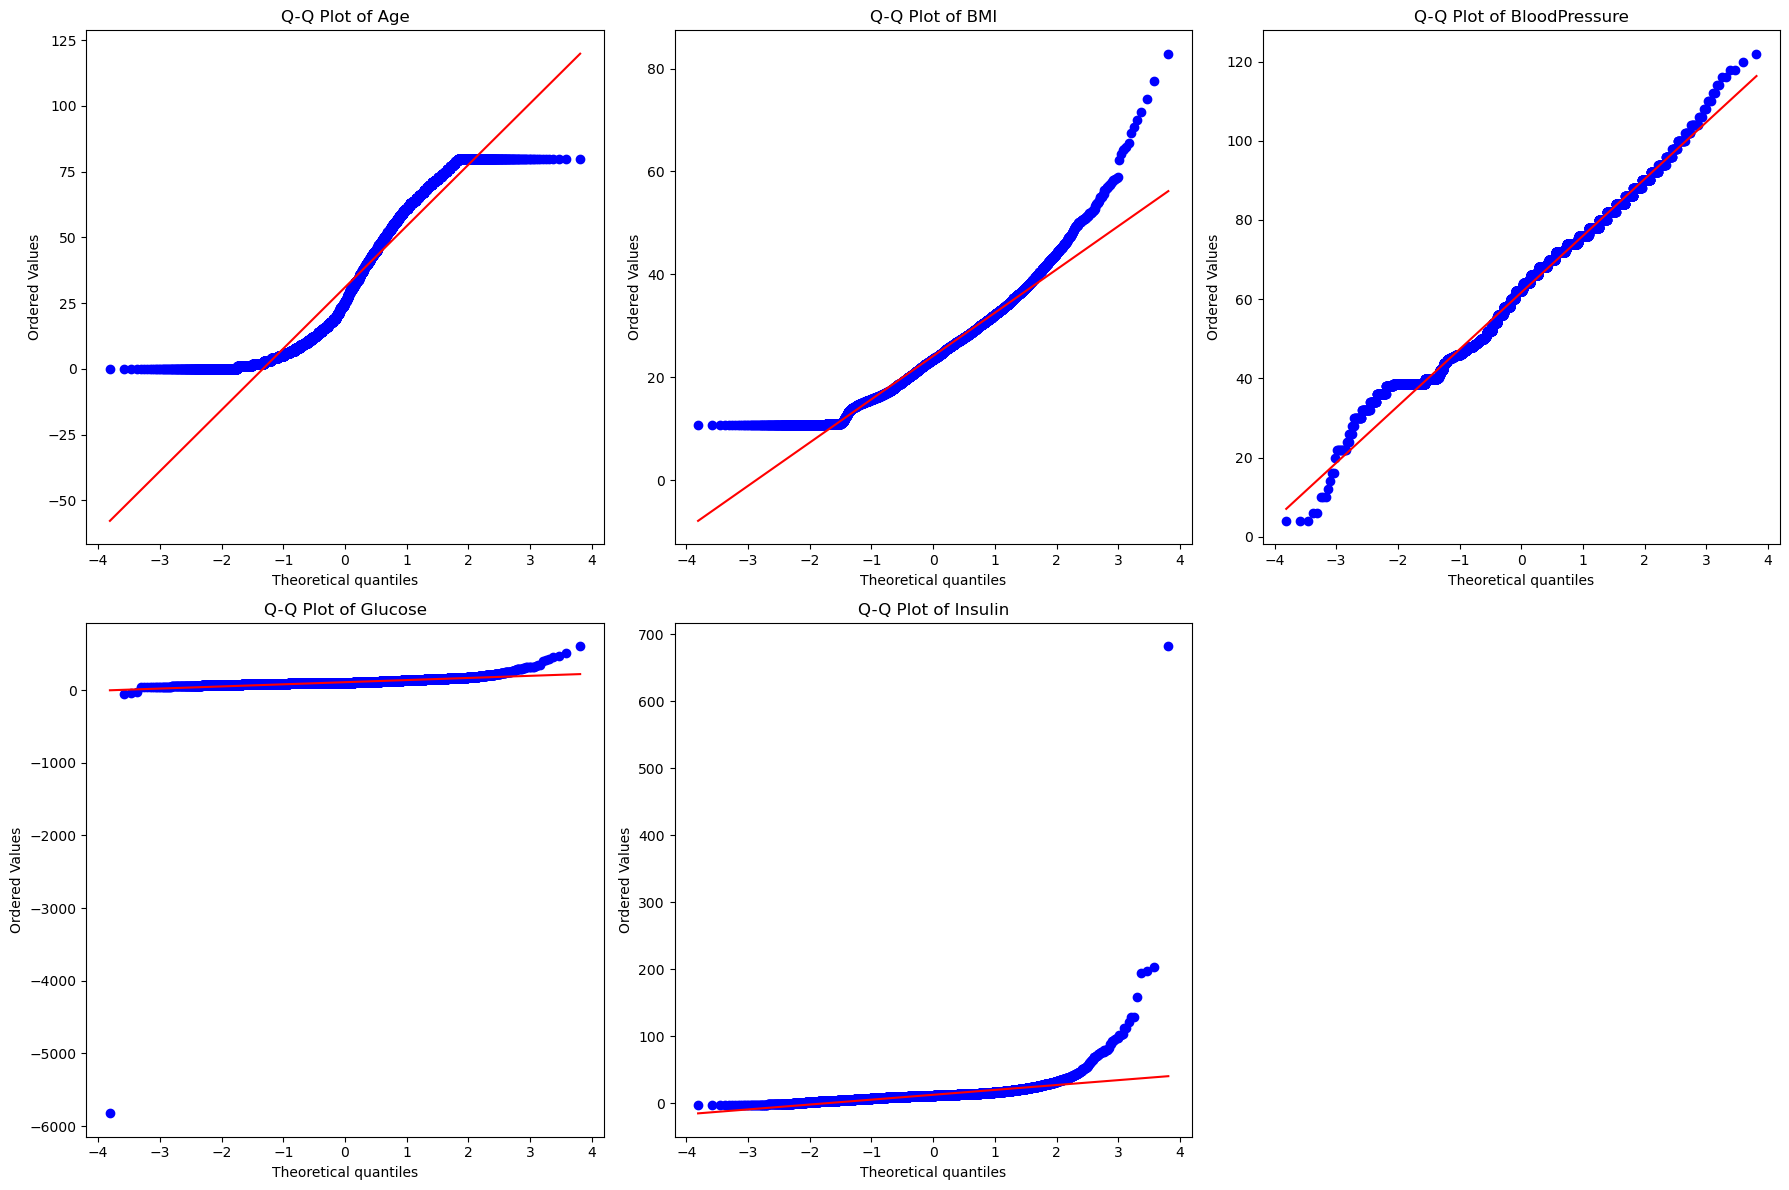

In [641]:
def qq_plot(data, feature, ax):
    stats.probplot(data[feature], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot of {feature}')

# List of features to plot
features = ['Age', 'BMI', 'BloodPressure', 'Glucose', 'Insulin']

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Flatten the array of axes for easier indexing
axs = axs.flatten()

# Plot Q-Q graphs for each feature
for i, feature in enumerate(features):
    qq_plot(filtered_data, feature, axs[i])

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


# Check Feature importance

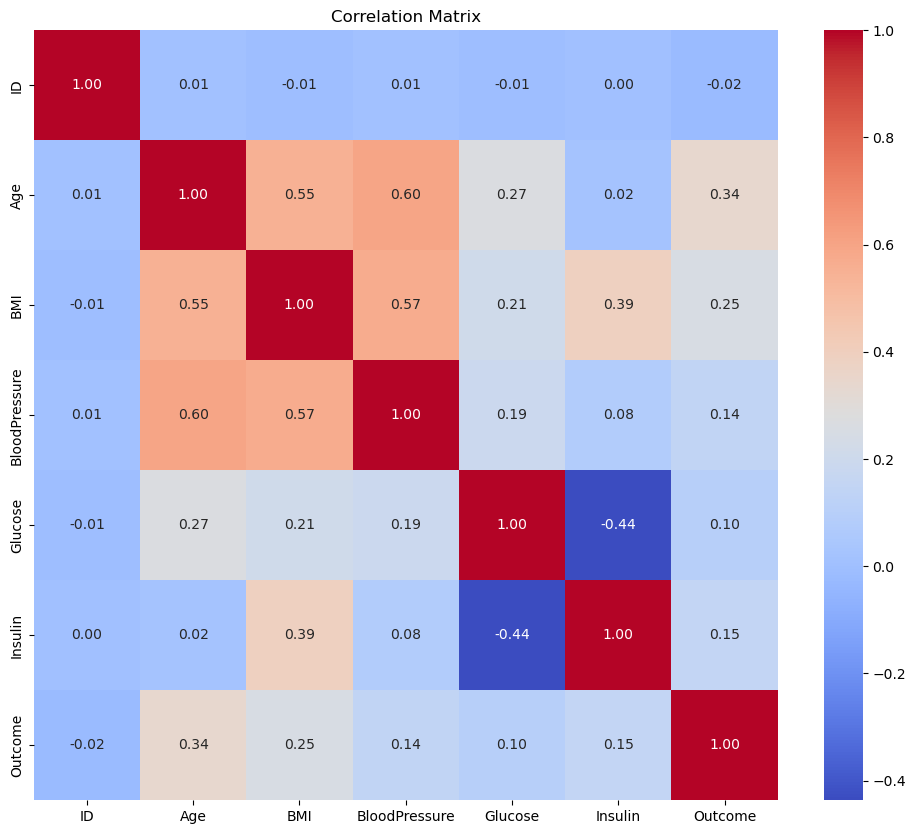

In [643]:
# Compute the correlation matrix
corr = filtered_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


# Define Features && last column "Outcome" as Class

In [645]:
# Define Features && last column "Outcome" as Class
#selected_features = ['Glucose', 'Insulin', 'BMI', 'Age']
selected_features = ['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure']

X = filtered_data[selected_features]
y = filtered_data.iloc[:, -1]   # Class = "Outcome"

# Split data (80:20)

In [647]:
# Split data (80 Train: 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Standardization)

In [649]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
#numerical_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
#df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Fit the scaler on the training data
#X_train_scaled = scaler.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

# Transform the testing data
#X_test_scaled = scaler.transform(X_test)
X_test = scaler.transform(X_test)

# Check Feature importance

[0.06929909 0.02069559 0.04106205 0.063664   0.02278775]


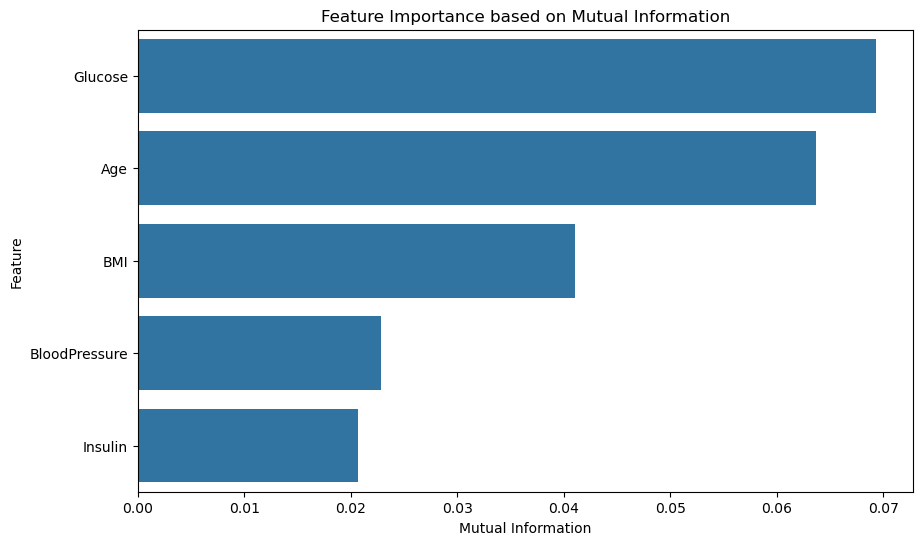

In [651]:
# Check Feature importance
# Calculate mutual information
#mi = mutual_info_classif(X_train, y_train)
mi = mutual_info_classif(X_train, y_train, random_state=42)
#mi = mutual_info_classif(X, y)
#mi = mutual_info_classif(X, y, random_state=42)
print(mi)

# Create a DataFrame for easier visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})

# Sort by importance
mi_df = mi_df.sort_values('Mutual Information', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Feature Importance based on Mutual Information')
plt.show()

# Processing Imbalance data with SMOTE

In [653]:
# Processing Imbalance data with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check "Outcome" balanced or not

In [655]:
# Check "Outcome" balanced or not
y_train.value_counts()

Outcome
0.0    7382
1.0    7382
Name: count, dtype: int64